<a href="https://colab.research.google.com/github/algroznykh/notebooks/blob/master/clip_embeddings_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#load model

In [1]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ecunhlg5
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-ecunhlg5
     |████████████████████████████████| 64 kB 2.4 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369106 sha256=d0a43efb31406b72cdff92dddc7406c4e2d7771f6fbce115fde4ac70d620ac10
  Stored in directory: /tmp/pip-ephem-wheel-cache-5l3ma2l2/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=4d1b1b4855730a4446aea32ae8e37cd33c9486b2d552d47f32c695af8a3ecc7c
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built clip ftfy


In [3]:
torch.__version__

'1.10.0+cu111'

In [4]:

import numpy as np
import torch


In [5]:


import clip

clip.available_models()



['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [6]:
model, preprocess = clip.load("RN50")
model.cuda().eval()

100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 52.7MiB/s]


CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

In [8]:
input_resolution = model.visual.input_resolution

In [9]:
input_resolution

224

# one embedding

In [10]:
from PIL import Image

In [19]:
shape = (input_resolution, input_resolution, 3)
ima = np.random.normal(size=shape, scale=.42).astype(np.float32)


In [21]:
im = Image.fromarray((ima * 255).astype('uint8'))

In [22]:
image = im.convert("RGB")

In [28]:

image_input = torch.tensor(np.expand_dims(preprocess(image), 0)).cuda()

In [29]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

In [30]:
image_features.shape

torch.Size([1, 1024])

In [31]:
image_features

tensor([[ 0.0206, -0.0565, -0.0776,  ..., -0.0029,  0.0090, -0.0555]],
       device='cuda:0')

In [32]:
import seaborn as sns


In [37]:
image_features[0]

tensor([ 0.0206, -0.0565, -0.0776,  ..., -0.0029,  0.0090, -0.0555],
       device='cuda:0')

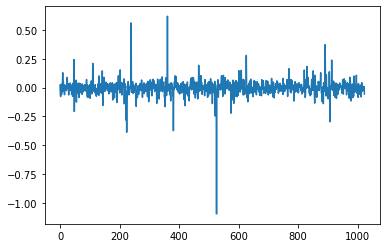

In [40]:
sns.lineplot(data=image_features[0].cpu().numpy())

In [42]:
image_features /= image_features.norm(dim=-1, keepdim=True)
image_features.cpu().numpy() @ image_features.cpu().numpy().T

array([[1.]], dtype=float32)

# batch embeddings

In [108]:
from torchvision import datasets, utils
from torchvision.transforms import ToTensor

In [117]:
data = datasets.CIFAR10(
    root="data",
    download=True,
    # transform=ToTensor()
)

Files already downloaded and verified


In [86]:
from matplotlib import pyplot as plt

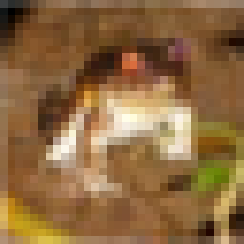

In [103]:
Image.fromarray((data[0][0].moveaxis(0, -1).cpu().numpy()*255).astype('uint8')).resize((244,244), Image.NEAREST)

In [162]:
ims = [data[i][0] for i in (np.random.randint(len(data)) for i in range(100))]

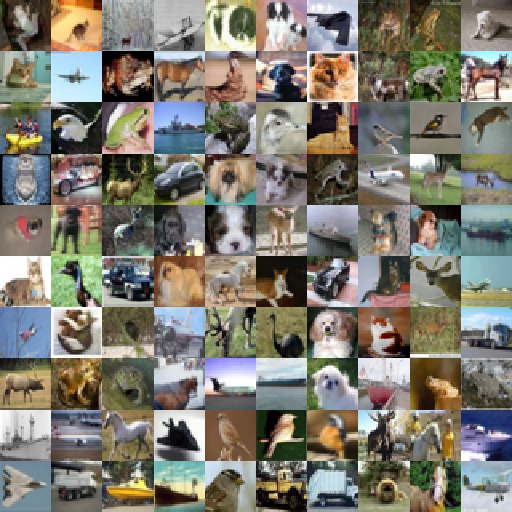

In [163]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid(ims, 10, 10).resize((512,512), Image.NEAREST)

In [154]:
# for tensors
# Image.fromarray((utils.make_grid(ims, nrow=3).moveaxis(0, -1).cpu().numpy() * 255).astype('uint8')).resize((244 * 3, 244 * 3), Image.NEAREST)

In [164]:
image_inputs = torch.tensor(np.stack([preprocess(im) for im in ims])).cuda()

In [165]:
with torch.no_grad():
    image_features = model.encode_image(image_inputs).float()

In [166]:
from sklearn.metrics.pairwise import cosine_similarity  

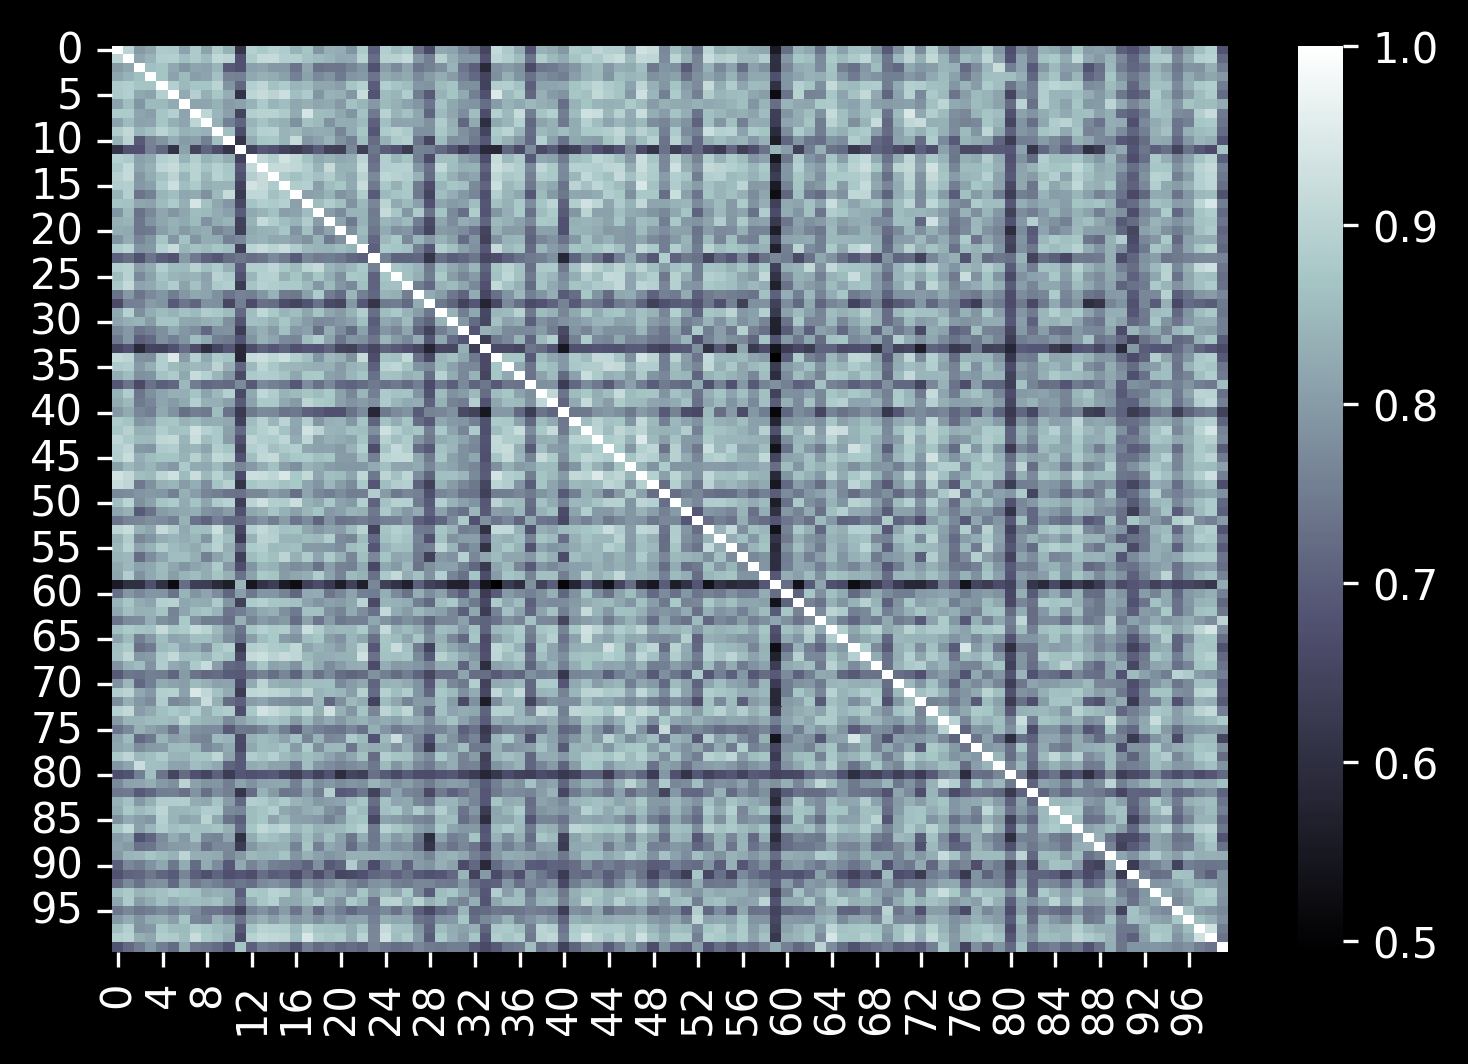

In [186]:
plt.figure(dpi=300)
sns.heatmap(data=cosine_similarity(image_features.cpu().numpy(), image_features.cpu().numpy()), cmap='bone')

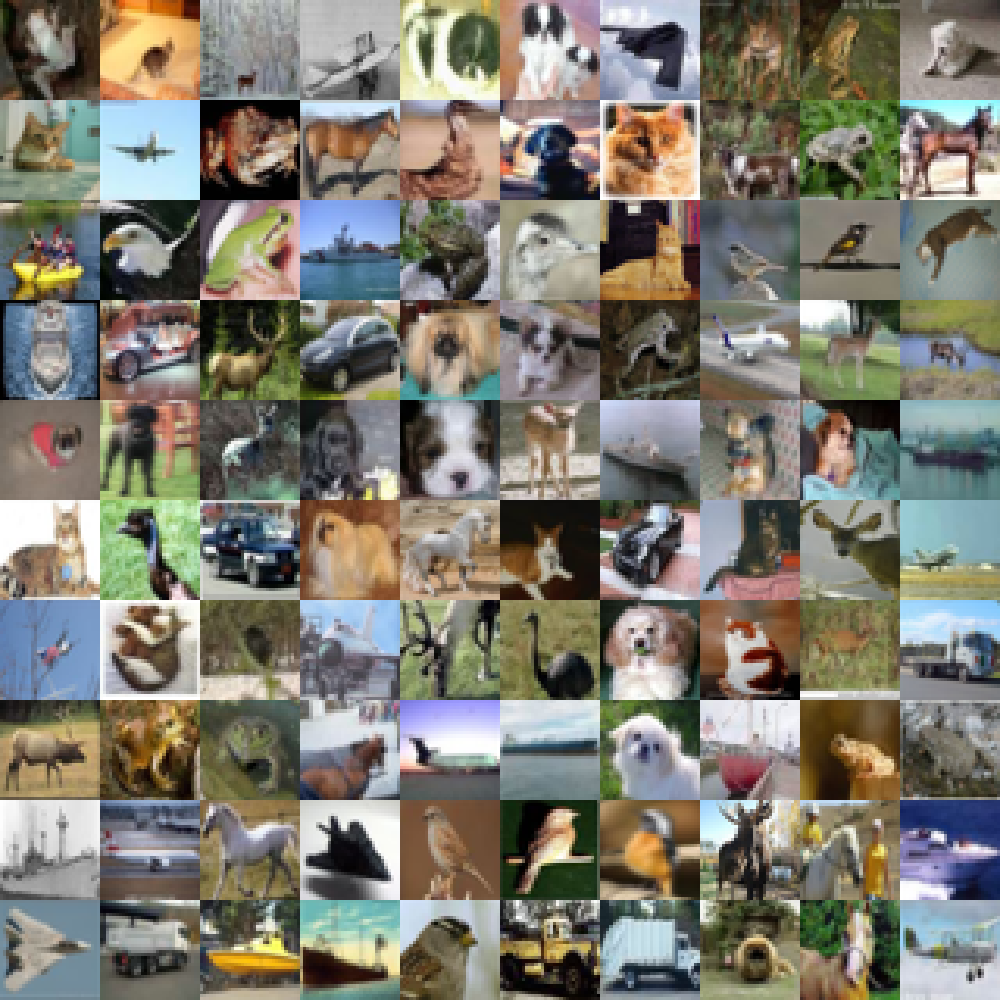

In [200]:
image_grid(ims, 10, 10).resize((1000,1000), Image.NEAREST)